# Chap 1 Introduction and Data Structure

**Outline**:
* ch1 intro and data structure
* ch2 logistic regression
* ch3 decision trees
* ch4 evaluating a credit risk model


Course focuses on the probability of default

## Components of expected loss (EL)
* Probability of default (PD)
* Exposure at defalult (EAD)  (amount of money due at a default moment )
* Loss given default (LGD)  (amount of the loss if there is a default = a percentage of the EAD)

This gives a formula for an expected loss:

$$EL = PD * EAD * LGD$$

#### Information used by banks

* Application information
    * income
    * marital status
    * ...
* Behavioral information
    * current account balance
    * payment arrears in account history
    * ..


In [1]:
##Exploring the credit data
library(data.table)
library(gmodels)
loan_data<-fread("loan_data.csv",  stringsAsFactors=TRUE)

str(loan_data)
paste('home_ownership stats with CrossTable() from gmodels')
CrossTable(loan_data$home_ownership)

Classes ‘data.table’ and 'data.frame':	29092 obs. of  8 variables:
 $ loan_status   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 1 2 1 ...
 $ loan_amnt     : int  5000 2400 10000 5000 3000 12000 9000 3000 10000 1000 ...
 $ int_rate      : num  10.7 NA 13.5 NA NA ...
 $ grade         : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 1 5 2 3 2 2 4 ...
 $ emp_length    : int  10 25 13 3 9 11 0 3 3 0 ...
 $ home_ownership: Factor w/ 4 levels "MORTGAGE","OTHER",..: 4 4 4 4 4 3 4 4 4 4 ...
 $ annual_inc    : num  24000 12252 49200 36000 48000 ...
 $ age           : int  33 31 24 39 24 28 22 22 28 22 ...
 - attr(*, ".internal.selfref")=<externalptr> 


[1] "home_ownership stats with CrossTable() from gmodels"


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  29092 

 
          |  MORTGAGE |     OTHER |       OWN |      RENT | 
          |-----------|-----------|-----------|-----------|
          |     12002 |        97 |      2301 |     14692 | 
          |     0.413 |     0.003 |     0.079 |     0.505 | 
          |-----------|-----------|-----------|-----------|



 


In [2]:
## see how rate of default is negatively correlated with grade

paste('CrossTable() on grade and loan_status')
CrossTable(loan_data$grade, loan_data$loan_status, prop.r = TRUE,
prop.c = FALSE, prop.t = FALSE, prop.chisq = FALSE)

[1] "CrossTable() on grade and loan_status"


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|-------------------------|

 
Total Observations in Table:  29092 

 
                | loan_data$loan_status 
loan_data$grade |         0 |         1 | Row Total | 
----------------|-----------|-----------|-----------|
              A |      9084 |       565 |      9649 | 
                |     0.941 |     0.059 |     0.332 | 
----------------|-----------|-----------|-----------|
              B |      8344 |       985 |      9329 | 
                |     0.894 |     0.106 |     0.321 | 
----------------|-----------|-----------|-----------|
              C |      4904 |       844 |      5748 | 
                |     0.853 |     0.147 |     0.198 | 
----------------|-----------|-----------|-----------|
              D |      2651 |       580 |      3231 | 
                |     0.820 |     0.180 |     0.111 | 
----------------|-----------|-----------|-----------|
              E |  

List of 6
 $ breaks  : num [1:13] 0 500000 1000000 1500000 2000000 2500000 3000000 3500000 4000000 4500000 ...
 $ counts  : int [1:12] 29045 38 5 2 1 0 0 0 0 0 ...
 $ density : num [1:12] 2.00e-06 2.61e-09 3.44e-10 1.37e-10 6.87e-11 ...
 $ mids    : num [1:12] 250000 750000 1250000 1750000 2250000 2750000 3250000 3750000 4250000 4750000 ...
 $ xname   : chr "loan_data$annual_inc"
 $ equidist: logi TRUE
 - attr(*, "class")= chr "histogram"


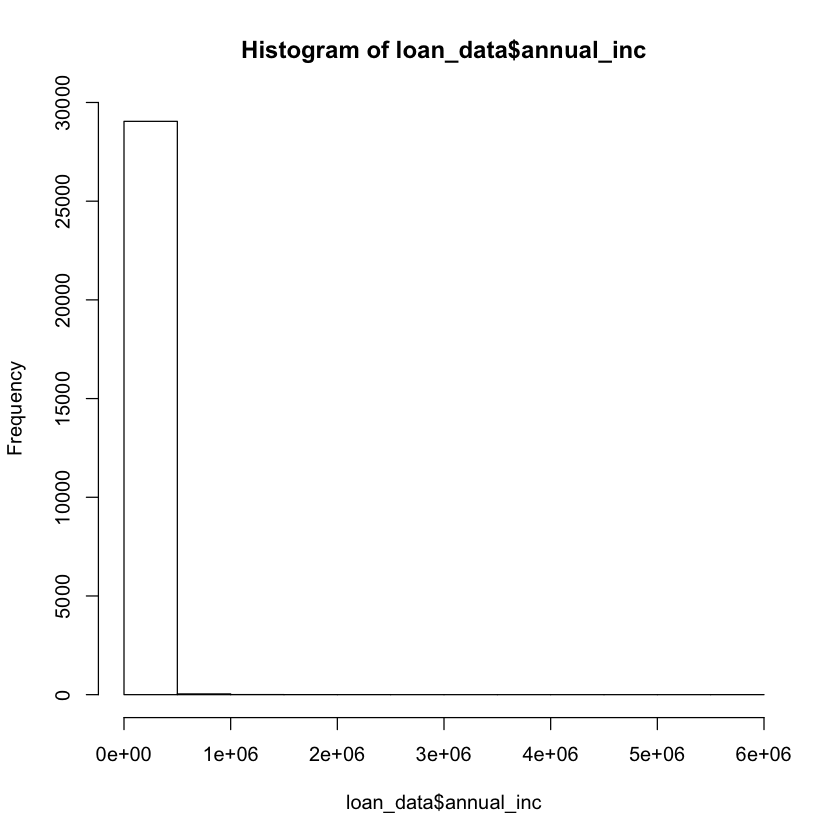

In [3]:
### Histograms (checking for breaks)
hist_1<-hist(loan_data$annual_inc)
str(hist_1)